<a href="https://colab.research.google.com/github/osmankultur3/transfer-learning-disease-detection/blob/master/Diabetic_Retinopaty_Classification_with_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##########################################################
# Date: 09.02.2020
# Name: Osman R Kultur
# Email: osmankultur3@gmail.com
##########################################################

# PART 1: Get The Messidor Databese Samples From The Drive
from google.colab import drive
drive.mount('/content/gdrive')
# drive.flush_and_unmount()
!unzip -qq '/content/gdrive/My Drive/DR/dataset.zip'
# make sure you have 20 photos in the workspace under the /test dircectory
!ls '/content/dataset/test'
# Now we have 20 images for each grade(0,1,2,3). In total, we have 100 images

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Using TensorFlow backend.


Found 80 images belonging to 4 classes.
Found 20 images belonging to 5 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


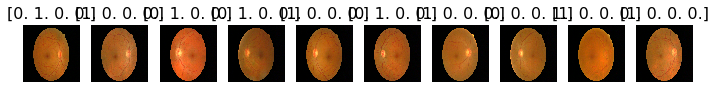

In [ ]:
# PART 2 : Data Acquisition
import tensorflow as tf
import numpy as np
import os
import pandas as pd

import keras
from keras import backend as K
from keras.preprocessing.image import load_img, save_img
from keras.preprocessing.image import img_to_array, array_to_img
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
from multiprocessing import Pool
from tqdm import tqdm_notebook as tqdm

from PIL import Image

np.random.seed(42)

DESIRED_WIDTH = 224 #Change back to 224
DESIRED_HEIGHT = 224

train_path = '/content/dataset/training/'
valid_path = '/content/dataset/training/'
test_path =  '/content/dataset/test/'


test_batches = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.255)

train_batches = ImageDataGenerator(  preprocessing_function=preprocess_input,
    rescale=1./255,
    rotation_range=40,     # randomly rotate pictures
    width_shift_range=0.1, # randomly translate pictures
    height_shift_range=0.1, 
    shear_range=0.2,       # randomly apply shearing
    zoom_range=0.2,        # random zoom range
    horizontal_flip=True)  # randomly flip image

train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(DESIRED_WIDTH,DESIRED_HEIGHT), classes=['0', '1', '2','3'], batch_size=10)
#train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['dog', 'cat'], batch_size=10)
#valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(DESIRED_WIDTH,DESIRED_HEIGHT), classes=['0', '1', '2','3'], batch_size=10)
#test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['0', '1', '2','3'], batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(DESIRED_WIDTH,DESIRED_HEIGHT), batch_size=10)

# PLOT
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

imgs, labels = next(train_batches)
plots(imgs, titles=labels)



In [ ]:
# PART 3: Model Creation by Utilizing Transfer Learning method with the ResNet50 model
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization

model = Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', input_shape=(DESIRED_WIDTH,DESIRED_HEIGHT,3)))

model.add(Flatten())
model.add(Dense(1280))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1280))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(640))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.7))

model.add(Dense(4,activation='softmax'))

adam = keras.optimizers.Adam(lr=0.00001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1280)              128451840 
_________________________________________________________________
batch_normalization_1 (Batch (None, 1280)              5120      
_________________________________________________________________
activation_50 (Activation)   (None, 1280)              0         
_________________________________________________________________
dro

In [ ]:
# PART 4: Train the  Model


from keras.callbacks import ModelCheckpoint
filepath = "resnet50-weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_acc', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(
        train_batches,
        steps_per_epoch=8,
        epochs=200,
        callbacks=callbacks_list,
        verbose=2)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/200
 - 28s - loss: 2.2741 - acc: 0.3000
Epoch 2/200


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 - 2s - loss: 2.2552 - acc: 0.2500
Epoch 3/200
 - 2s - loss: 2.0431 - acc: 0.3875
Epoch 4/200
 - 2s - loss: 1.9390 - acc: 0.3000
Epoch 5/200
 - 2s - loss: 2.1302 - acc: 0.2250
Epoch 6/200
 - 2s - loss: 2.0185 - acc: 0.3250
Epoch 7/200
 - 2s - loss: 1.7988 - acc: 0.3750
Epoch 8/200
 - 2s - loss: 1.9004 - acc: 0.3125
Epoch 9/200
 - 2s - loss: 1.4361 - acc: 0.4750
Epoch 10/200
 - 2s - loss: 1.8916 - acc: 0.3250
Epoch 11/200
 - 2s - loss: 1.5105 - acc: 0.5125
Epoch 12/200
 - 2s - loss: 1.5482 - acc: 0.4125
Epoch 13/200
 - 2s - loss: 1.4380 - acc: 0.4000
Epoch 14/200
 - 2s - loss: 1.4531 - acc: 0.4625
Epoch 15/200
 - 2s - loss: 1.7024 - acc: 0.4375
Epoch 16/200
 - 2s - loss: 1.6477 - acc: 0.4250
Epoch 17/200
 - 2s - loss: 1.4001 - acc: 0.4500
Epoch 18/200
 - 2s - loss: 1.6058 - acc: 0.4625
Epoch 19/200
 - 2s - loss: 1.4216 - acc: 0.4750
Epoch 20/200
 - 2s - loss: 1.2376 - acc: 0.5500
Epoch 21/200
 - 2s - loss: 1.3396 - acc: 0.4625
Epoch 22/200
 - 2s - loss: 1.4062 - acc: 0.4750
Epoch 23/200

KeyError: ignored

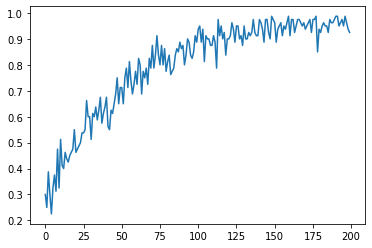

In [ ]:
# PART 5: Plot The Resulting Accuracy of the Model
history.history.keys()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# PART 6: Assesment of the Prediction and Confusion Matrix Plot
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

print("NOW WE SEE CLASS 0: \n")
print("******************************************************")
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
print("test_labels : \n", test_labels)
test_labels = test_labels[:,0]
print("test_labels[:,0] : \n", test_labels)
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))
print("predictions: \n",predictions)
print("predictions[:,0] : \n",predictions[:,0])
print("np.round(predictions[:,0] : \n",np.round(predictions[:,0]))
cm_plots_labels = ["Normal","Mild","Moderate","Severe"]
plt.figure()
#plot_confusion_matrix(cm, cm_plots_labels)
print("******************************************************")
print("NOW WE SEE CLASS 1: ")
print("******************************************************")
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
test_labels = test_labels[:,1]
print("test_labels: \n", test_labels)
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
cm = confusion_matrix(test_labels, np.round(predictions[:,1]))
print("predictions: \n",predictions)
print("predictions[:,0] : \n",predictions[:,1])
print("np.round(predictions[:,0] : \n",np.round(predictions[:,1]))
cm_plots_labels = ["Normal","Mild","Moderate","Severe"]
plt.figure()
#plot_confusion_matrix(cm, cm_plots_labels)

print("******************************************************")
print("NOW WE SEE CLASS 2")
print("******************************************************")
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
test_labels = test_labels[:,2]
print("test_labels: \n", test_labels)
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
cm = confusion_matrix(test_labels, np.round(predictions[:,2]))
print("predictions: \n",predictions)
print("predictions[:,0] : \n",predictions[:,2])
print("np.round(predictions[:,0] : \n",np.round(predictions[:,2]))
cm_plots_labels = ["Normal","Mild","Moderate","Severe"]
plt.figure()
#plot_confusion_matrix(cm, cm_plots_labels)
print("******************************************************")
print("NOW WE SEE CLASS 3: ")
print("******************************************************")
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)
test_labels = test_labels[:,3]
print("test_labels: \n", test_labels)
predictions = model.predict_generator(test_batches, steps=1, verbose=0)
cm = confusion_matrix(test_labels, np.round(predictions[:,3]))
print("predictions: \n",predictions)
print("predictions[:,0] : \n",predictions[:,3])
print("np.round(predictions[:,0] : \n",np.round(predictions[:,3]))
cm_plots_labels = ["Normal","Mild","Moderate","Severe"]
plt.figure()
#plot_confusion_matrix(cm, cm_plots_labels)
